In [1]:
# Firsimport findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('sbab033').getOrCreate()



In [2]:
df= spark.read.csv('balanced_data.csv',header=True,inferSchema=True)

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import (RandomForestClassifier, GBTClassifier, DecisionTreeClassifier,LogisticRegression)

In [4]:
# A few things we need to do before Spark can accept the data!
# It needs to be in the form of two columns: "label" and "features".

# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [5]:
df.printSchema()

root
 |-- age: double (nullable = true)
 |-- creatinine_phosphokinase: double (nullable = true)
 |-- ejection_fraction: double (nullable = true)
 |-- platelets: double (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- serum_sodium: double (nullable = true)
 |-- time: double (nullable = true)
 |-- anaemia: integer (nullable = true)
 |-- DEATH_EVENT: integer (nullable = true)



In [6]:
df.columns

['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'time',
 'anaemia',
 'DEATH_EVENT']

In [7]:
assembler = VectorAssembler(
  inputCols=['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'time',
 'anaemia'],outputCol="features")

In [8]:
df1 = assembler.transform(df)

In [9]:
# Split the data into training and test sets (20% held out for testing).
(train_data, test_data) = df1.randomSplit([0.8, 0.2],seed = 1)

# 6.2

In [10]:
dtc = DecisionTreeClassifier(labelCol='DEATH_EVENT',featuresCol='features')
rfc = RandomForestClassifier(labelCol='DEATH_EVENT',featuresCol='features')
gbt = GBTClassifier(labelCol='DEATH_EVENT',featuresCol='features')
lrc = LogisticRegression(labelCol='DEATH_EVENT',featuresCol='features')

In [11]:
# Train the models (it's three models, so it might take some time).
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
gbt_model = gbt.fit(train_data)
lrc_model = lrc.fit(train_data)

In [12]:
dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)
lrc_predictions = lrc_model.transform(test_data)

In [13]:
# Let's start off with binary classification.
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Note that the label column isn't named label, it's named PrivateIndex in this case.
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'DEATH_EVENT')

In [14]:
# This is the area under the curve. This indicates that the data is highly seperable.
print("DTC")
print(my_binary_eval.evaluate(dtc_predictions))

# RFC improves accuracy but also model complexity. RFC outperforms DTC in nearly every situation.
print("RFC")
print(my_binary_eval.evaluate(rfc_predictions))

# We can't repeat these exact steps for GBT.
my_binary_gbt_eval = BinaryClassificationEvaluator(labelCol='DEATH_EVENT', rawPredictionCol='prediction')
print("GBT")
print(my_binary_gbt_eval.evaluate(gbt_predictions))

print("LRC")
print(my_binary_gbt_eval.evaluate(lrc_predictions))


DTC
0.8719594594594595
RFC
0.9527027027027027
GBT
0.8439189189189189
LRC
0.7658783783783785


In [15]:
# Select (prediction, true label) and compute test error. 
acc_evaluator = MulticlassClassificationEvaluator(labelCol="DEATH_EVENT", predictionCol="prediction", metricName="accuracy")

In [16]:
dtc_acc = acc_evaluator.evaluate(dtc_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_predictions)
gbt_acc = acc_evaluator.evaluate(gbt_predictions)
lrc_acc = acc_evaluator.evaluate(lrc_predictions)

In [17]:
# Let's do something a bit more complex in terms of printing, just so it's formatted nicer. 
print("Here are the results!")
print('-'*40)
print('A single decision tree has an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*40)
print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
print('-'*40)
print('An ensemble using GBT has an accuracy of: {0:2.2f}%'.format(gbt_acc*100))
print('-'*40)
print('An ensemble using Logistic Reggression has an accuracy of: {0:2.2f}%'.format(gbt_acc*100))

Here are the results!
----------------------------------------
A single decision tree has an accuracy of: 88.31%
----------------------------------------
A random forest ensemble has an accuracy of: 85.71%
----------------------------------------
An ensemble using GBT has an accuracy of: 84.42%
----------------------------------------
An ensemble using Logistic Reggression has an accuracy of: 84.42%


# 6.3

depth: 1
Accuracy gini: 0.8051948051948052
Accuracy etropy: 0.8051948051948052
depth: 2
Accuracy gini: 0.8571428571428571
Accuracy etropy: 0.8571428571428571
depth: 3
Accuracy gini: 0.8441558441558441
Accuracy etropy: 0.8701298701298701
depth: 4
Accuracy gini: 0.8571428571428571
Accuracy etropy: 0.8441558441558441
depth: 5
Accuracy gini: 0.8441558441558441
Accuracy etropy: 0.8571428571428571
depth: 6
Accuracy gini: 0.8181818181818182
Accuracy etropy: 0.8311688311688312
depth: 7
Accuracy gini: 0.8311688311688312
Accuracy etropy: 0.8441558441558441
depth: 8
Accuracy gini: 0.8311688311688312
Accuracy etropy: 0.8181818181818182
depth: 9
Accuracy gini: 0.8311688311688312
Accuracy etropy: 0.8051948051948052


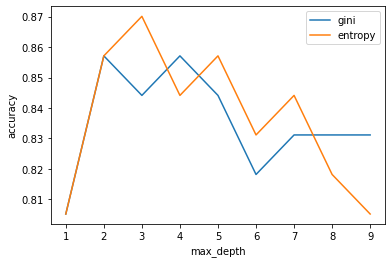

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,10):
 dt = DecisionTreeClassifier(labelCol='DEATH_EVENT',featuresCol='features', maxDepth=i,seed=1,maxBins=552,impurity='gini')
 model = dt.fit(train_data)
 pred = model.transform(test_data)
 print("depth:",i )
 mev = MulticlassClassificationEvaluator(labelCol="DEATH_EVENT", predictionCol="prediction", metricName="accuracy")
 #print("Accuracy:", mev.evaluate(pred))
 Accuracy= mev.evaluate(pred)
 print("Accuracy gini:",Accuracy)
 acc_gini.append(mev.evaluate(pred))
 ####
 dt = DecisionTreeClassifier(labelCol='DEATH_EVENT',featuresCol='features', maxDepth=i,seed = 1,maxBins=552,impurity='entropy')
 model = dt.fit(train_data)
 pred = model.transform(test_data)
 #print("depth:",i )
 mev = MulticlassClassificationEvaluator(labelCol="DEATH_EVENT", predictionCol="prediction", metricName="accuracy")
 #print("Accuracy:", mev.evaluate(pred))
 Accuracy= mev.evaluate(pred)
 print("Accuracy etropy:",Accuracy)
 acc_entropy.append(mev.evaluate(pred))
 ####
 max_depth.append(i)
 d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

number of trees: 1
Accuracy gini: 0.8571428571428571
Accuracy etropy: 0.8181818181818182
number of trees: 2
Accuracy gini: 0.8441558441558441
Accuracy etropy: 0.8311688311688312
number of trees: 3
Accuracy gini: 0.8571428571428571
Accuracy etropy: 0.8181818181818182
number of trees: 4
Accuracy gini: 0.8961038961038961
Accuracy etropy: 0.8831168831168831
number of trees: 5
Accuracy gini: 0.8701298701298701
Accuracy etropy: 0.8831168831168831
number of trees: 6
Accuracy gini: 0.8701298701298701
Accuracy etropy: 0.8831168831168831
number of trees: 7
Accuracy gini: 0.8701298701298701
Accuracy etropy: 0.922077922077922
number of trees: 8
Accuracy gini: 0.8701298701298701
Accuracy etropy: 0.8961038961038961
number of trees: 9
Accuracy gini: 0.8571428571428571
Accuracy etropy: 0.8441558441558441
number of trees: 10
Accuracy gini: 0.8701298701298701
Accuracy etropy: 0.8831168831168831
number of trees: 11
Accuracy gini: 0.8701298701298701
Accuracy etropy: 0.8961038961038961
number of trees: 12


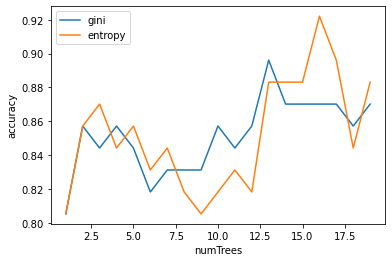

In [19]:
numTrees=[]
for i in range(1,20):
 #dt = DecisionTreeClassifier(labelCol='DEATH_EVENT',featuresCol='features', maxDepth=i,seed=1,maxBins=552,impurity='gini')
 dt= RandomForestClassifier(labelCol='DEATH_EVENT', featuresCol="features", numTrees=i, 
                                maxDepth=7, maxBins=552,impurity='gini',seed=1)
 model = dt.fit(train_data)
 pred = model.transform(test_data)
 print("number of trees:",i )
 mev = MulticlassClassificationEvaluator(labelCol="DEATH_EVENT", predictionCol="prediction", metricName="accuracy")
 #print("Accuracy:", mev.evaluate(pred))
 Accuracy= mev.evaluate(pred)
 print("Accuracy gini:",Accuracy)
 acc_gini.append(mev.evaluate(pred))
 ####
 dt= RandomForestClassifier(labelCol='DEATH_EVENT', featuresCol="features", numTrees=i, 
                                maxDepth=7, maxBins=552,impurity='entropy',seed=1)
 model = dt.fit(train_data)
 pred = model.transform(test_data)
 #print("depth:",i )
 #mev = MulticlassClassificationEvaluator(labelCol="DEATH_EVENT", predictionCol="prediction", metricName="accuracy")
 #print("Accuracy:", mev.evaluate(pred))
 Accuracy= mev.evaluate(pred)
 print("Accuracy etropy:",Accuracy)
 acc_entropy.append(mev.evaluate(pred))
 ####
 numTrees.append(i)
 d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'numTrees':pd.Series(numTrees)})
# visualizing changes in parameters
plt.plot('numTrees','acc_gini', data=d, label='gini')
plt.plot('numTrees','acc_entropy', data=d, label='entropy')
plt.xlabel('numTrees')
plt.ylabel('accuracy')
plt.legend()

number of iteration: 1
Accuracy Variance: 0.8311688311688312
number of iteration: 2
Accuracy Variance: 0.8311688311688312
number of iteration: 3
Accuracy Variance: 0.8311688311688312
number of iteration: 4
Accuracy Variance: 0.8181818181818182
number of iteration: 5
Accuracy Variance: 0.8311688311688312
number of iteration: 6
Accuracy Variance: 0.8181818181818182
number of iteration: 7
Accuracy Variance: 0.8181818181818182
number of iteration: 8
Accuracy Variance: 0.8181818181818182
number of iteration: 9
Accuracy Variance: 0.8181818181818182
number of iteration: 10
Accuracy Variance: 0.8181818181818182
number of iteration: 11
Accuracy Variance: 0.8181818181818182
number of iteration: 12
Accuracy Variance: 0.8181818181818182
number of iteration: 13
Accuracy Variance: 0.8181818181818182
number of iteration: 14
Accuracy Variance: 0.8181818181818182
number of iteration: 15
Accuracy Variance: 0.8181818181818182
number of iteration: 16
Accuracy Variance: 0.8181818181818182
number of iterati

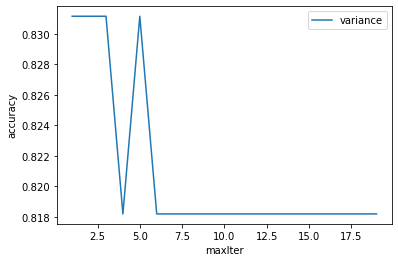

In [20]:
maxIter=[]
acc_=[]
for i in range(1,20):
 #dt = DecisionTreeClassifier(labelCol='DEATH_EVENT',featuresCol='features', maxDepth=i,seed=1,maxBins=552,impurity='gini')
 dt= GBTClassifier(labelCol='DEATH_EVENT', featuresCol="features", maxIter=i, 
                                maxDepth=7, maxBins=552,seed=1)
 model = dt.fit(train_data)
 pred = model.transform(test_data)
 print("number of iteration:",i )
 mev = MulticlassClassificationEvaluator(labelCol="DEATH_EVENT", predictionCol="prediction", metricName="accuracy")
 #print("Accuracy:", mev.evaluate(pred))
 Accuracy= mev.evaluate(pred)
 print("Accuracy Variance:",Accuracy)
 acc_.append(mev.evaluate(pred))
 ####
 
 maxIter.append(i)
 #maxIter.append(i)
d = pd.DataFrame({'acc_':pd.Series(acc_),
 'maxIter':pd.Series(maxIter)})
# visualizing changes in parameters
#plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('maxIter','acc_', data=d, label='variance')
plt.xlabel('maxIter')
plt.ylabel('accuracy')
plt.legend()

# 7.1

In [21]:
(train_data, test_data) = df1.randomSplit([0.8, 0.2],seed = 1)

In [22]:
dt = DecisionTreeClassifier(labelCol='DEATH_EVENT',featuresCol='features', maxDepth=3,maxBins=552,impurity='gini',seed = 1)
#split 80:20
print("Accuract and AUC on split 80:20")
dtmodel = dt.fit(train_data)
dtpred = dtmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
print("Accuracy:",mev.evaluate(dtpred))




Accuract and AUC on split 80:20
AUC: 0.8567567567567567
Accuracy: 0.8441558441558441


In [23]:
#split 70:30
print("Accuract and AUC on split 70:30")
(train_data, test_data) = df1.randomSplit([0.7, 0.3], seed = 1)
dtmodel = dt.fit(train_data)
dtpred = dtmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
print("Accuracy:",mev.evaluate(dtpred))


Accuract and AUC on split 70:30
AUC: 0.8430724484399787
Accuracy: 0.8292682926829268


In [24]:
#slpit 60:40
print("Accuract and AUC on split 75:25")
(train_data, test_data) = df1.randomSplit([0.6,0.4], seed = 1)
dtmodel = dt.fit(train_data)
dtpred = dtmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
print("Accuracy:",mev.evaluate(dtpred))

Accuract and AUC on split 75:25
AUC: 0.8420058139534883
Accuracy: 0.8373493975903614


# 7.2(DM 1)

In [25]:
final = df1.select("features", "DEATH_EVENT")
(train_data, test_data) = final.randomSplit([0.8, 0.2], seed = 1)

Decision Tree

In [26]:
dt = DecisionTreeClassifier(labelCol='DEATH_EVENT',featuresCol='features', maxDepth=3,maxBins=552,impurity='gini',seed=1)
dtmodel = dt.fit(train_data)
dtpred = dtmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
accuracy=mev.evaluate(dtpred)
print("Accuracy:",mev.evaluate(dtpred))
print("Test Error = %g" % (1.0 - accuracy))

AUC: 0.8567567567567567
Accuracy: 0.8441558441558441
Test Error = 0.155844


Random Forest

In [27]:
rf= RandomForestClassifier(labelCol='DEATH_EVENT', featuresCol="features", numTrees=4, 
                                maxDepth=7, maxBins=552,impurity='gini',seed=1)
rfmodel = rf.fit(train_data)
dtpred = rfmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
accuracy=mev.evaluate(dtpred)
print("Accuracy:",mev.evaluate(dtpred))
print("Test Error = %g" % (1.0 - accuracy))

AUC: 0.9334459459459459
Accuracy: 0.8961038961038961
Test Error = 0.103896


GBTClassifier

In [28]:
gbt= GBTClassifier(labelCol='DEATH_EVENT', featuresCol="features", maxIter=11, 
                                maxDepth=7, maxBins=552,seed=1)
gbtmodel = gbt.fit(train_data)
dtpred = gbtmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
accuracy=mev.evaluate(dtpred)
print("Accuracy:",mev.evaluate(dtpred))
print("Test Error = %g" % (1.0 - accuracy))

AUC: 0.914527027027027
Accuracy: 0.8181818181818182
Test Error = 0.181818


# 7.3

['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'anaemia']


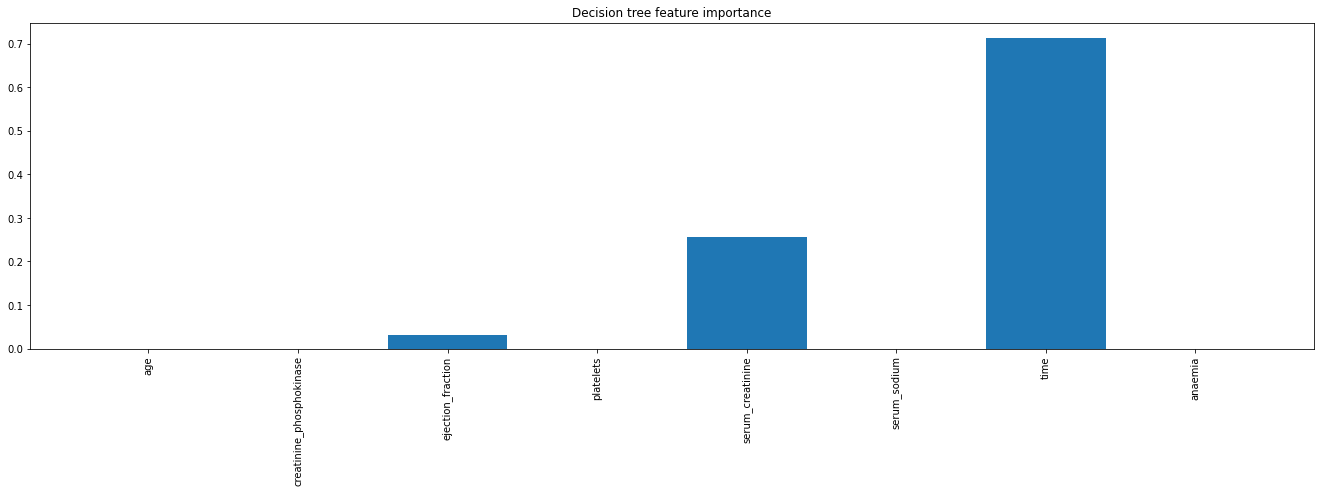

In [29]:
import matplotlib.pyplot as plt
X = df.columns
X.remove("DEATH_EVENT") #label
print(X)
plt.figure(figsize=(23,6))
#plt.bar(x, dt.featureImportances)
plt.bar(X, dtmodel.featureImportances)
plt.xticks(rotation=90)
plt.title("Decision tree feature importance")
plt.show()


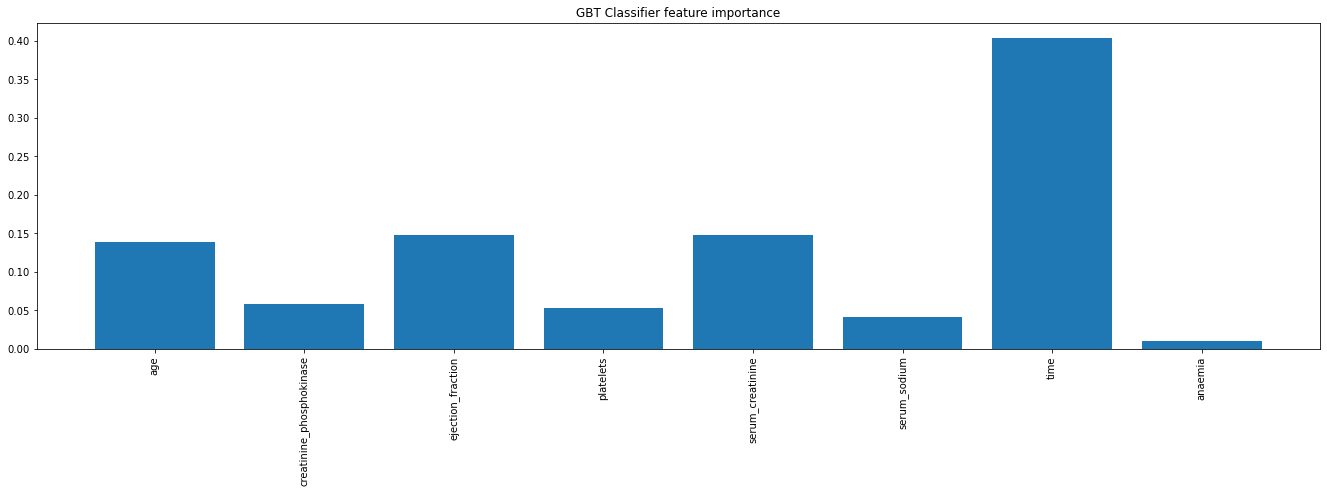

In [30]:
x = df.columns
x.remove("DEATH_EVENT") #label
plt.figure(figsize=(23,6))
plt.bar(x, gbtmodel.featureImportances)
plt.xticks(rotation=90)
plt.title("GBT Classifier feature importance")
plt.show()

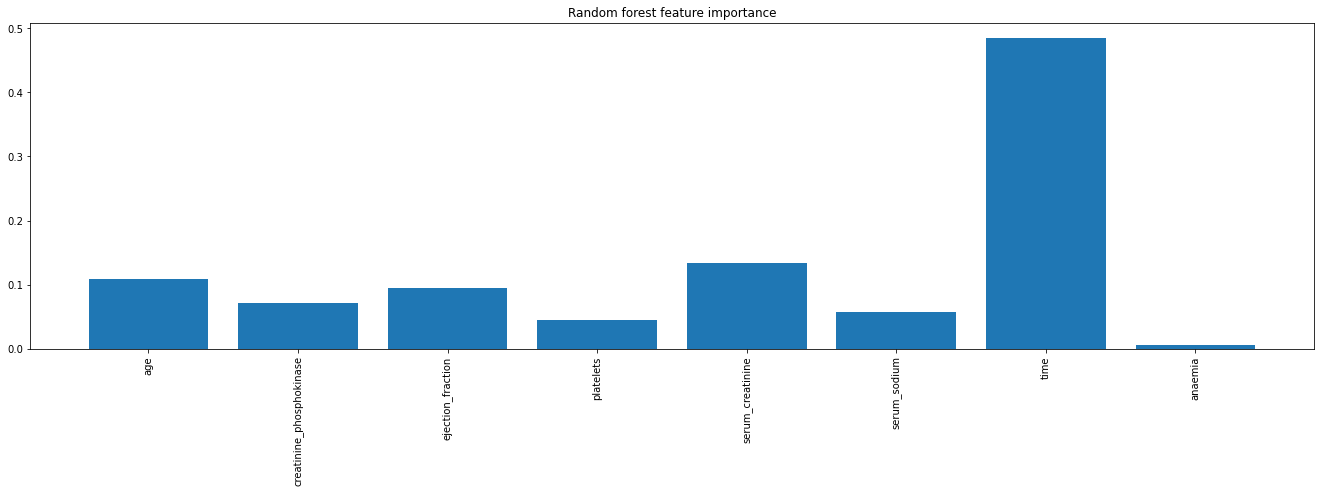

In [31]:
x = df.columns
x.remove("DEATH_EVENT") #label
plt.figure(figsize=(23,6))
plt.bar(x, rfmodel.featureImportances)
plt.xticks(rotation=90)
plt.title("Random forest feature importance")
plt.show()

# 7.2(DM-2)

In [32]:
assembler = VectorAssembler(
  inputCols=['ejection_fraction',
 'serum_creatinine'],outputCol="features")

In [33]:
df2 = assembler.transform(df)

In [34]:
(train_data, test_data) = df2.randomSplit([0.8, 0.2], seed = 1)

Decision Tree

In [35]:
dt = DecisionTreeClassifier(labelCol='DEATH_EVENT',featuresCol='features', maxDepth=3,maxBins=552,impurity='gini',seed=1)
dtmodel = dt.fit(train_data)
dtpred = dtmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
accuracy=mev.evaluate(dtpred)
print("Accuracy:",mev.evaluate(dtpred))
print("Test Error = %g" % (1.0 - accuracy))

AUC: 0.7405405405405404
Accuracy: 0.7272727272727273
Test Error = 0.272727


Random Forest

In [36]:
rf= RandomForestClassifier(labelCol='DEATH_EVENT', featuresCol="features", numTrees=4, 
                                maxDepth=7, maxBins=552,impurity='gini',seed=1)
dtmodel = rf.fit(train_data)
dtpred = dtmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
accuracy=mev.evaluate(dtpred)
print("Accuracy:",mev.evaluate(dtpred))
print("Test Error = %g" % (1.0 - accuracy))

AUC: 0.7722972972972972
Accuracy: 0.7012987012987013
Test Error = 0.298701


GBT Classifier

In [37]:
gbt= GBTClassifier(labelCol='DEATH_EVENT', featuresCol="features", maxIter=11, 
                                maxDepth=7, maxBins=552,seed=1)
dtmodel = gbt.fit(train_data)
dtpred = dtmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
accuracy=mev.evaluate(dtpred)
print("Accuracy:",mev.evaluate(dtpred))
print("Test Error = %g" % (1.0 - accuracy))

AUC: 0.795608108108108
Accuracy: 0.7272727272727273
Test Error = 0.272727


# 8.5

1teration 1 (Used all freatures and imbalanced data)

In [38]:
df= spark.read.csv('cleaned_data.csv',header=True,inferSchema=True)

In [39]:
df.columns

['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'time',
 'anaemia',
 'diabetes',
 'high_blood_pressure',
 'sex',
 'DEATH_EVENT',
 'smoking']

In [40]:
assembler = VectorAssembler(
  inputCols=['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'time',
 'anaemia',
 'diabetes',
 'high_blood_pressure',
 'sex',
 'smoking'],outputCol="features")

In [41]:
df2 = assembler.transform(df)

In [42]:
(train_data, test_data) = df2.randomSplit([0.8, 0.2], seed = 1)

In [43]:
rf= RandomForestClassifier(labelCol='DEATH_EVENT', featuresCol="features", numTrees=4, 
                                maxDepth=7, maxBins=552,impurity='gini',seed=1)
rfmodel = rf.fit(train_data)
dtpred = rfmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
accuracy=mev.evaluate(dtpred)
print("Accuracy:",mev.evaluate(dtpred))
print("Test Error = %g" % (1.0 - accuracy))

AUC: 0.7790697674418605
Accuracy: 0.7758620689655172
Test Error = 0.224138


In [44]:
gbt= GBTClassifier(labelCol='DEATH_EVENT', featuresCol="features", maxIter=11, 
                                maxDepth=7, maxBins=552,seed=1)
gbtmodel = gbt.fit(train_data)
dtpred = gbtmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
accuracy=mev.evaluate(dtpred)
print("Accuracy:",mev.evaluate(dtpred))
print("Test Error = %g" % (1.0 - accuracy))

AUC: 0.7217054263565891
Accuracy: 0.7068965517241379
Test Error = 0.293103


Iteration 2(only 2 clinical features and imbalanced data)

In [45]:
assembler = VectorAssembler(
  inputCols=[
 'ejection_fraction',
 'serum_creatinine'],outputCol="features")

In [46]:
df3 = assembler.transform(df)

In [47]:
(train_data, test_data) = df3.randomSplit([0.8, 0.2], seed = 1)

In [48]:
rf= RandomForestClassifier(labelCol='DEATH_EVENT', featuresCol="features", numTrees=4, 
                                maxDepth=7, maxBins=552,impurity='gini',seed=1)
dtmodel = rf.fit(train_data)
dtpred = dtmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
accuracy=mev.evaluate(dtpred)
print("Accuracy:",mev.evaluate(dtpred))
print("Test Error = %g" % (1.0 - accuracy))

AUC: 0.6240310077519381
Accuracy: 0.6206896551724138
Test Error = 0.37931


In [49]:
gbt= GBTClassifier(labelCol='DEATH_EVENT', featuresCol="features", maxIter=11, 
                                maxDepth=7, maxBins=552,seed=1)
gbtmodel = gbt.fit(train_data)
dtpred = gbtmodel.transform(test_data)
print("AUC:",my_binary_eval.evaluate(dtpred))
accuracy=mev.evaluate(dtpred)
print("Accuracy:",mev.evaluate(dtpred))
print("Test Error = %g" % (1.0 - accuracy))

AUC: 0.6155038759689923
Accuracy: 0.6379310344827587
Test Error = 0.362069
